### 拉取历史股价数据

In [29]:
import pandas as pd
import numpy as np

# 从 numpy 数组中删除科学记数法
#安装 nsepy 库以获取股票价格
!pip install nsepy

############################################
# 使用 nsepy 库获取 Stock 数据
from nsepy import get_history
from datetime import datetime

startDate=datetime(2019, 1,1)
endDate=datetime(2020, 10, 5)

# 获取数据
StockData=get_history(symbol='INFY', start=startDate, end=endDate)
print(StockData.shape)
StockData.head()

(436, 14)


,Symbol,Series,Prev Close,Open,High,Low,Last,Close,VWAP,Volume,Turnover,Trades,Deliverable Volume,%Deliverble
Date,,,,,,,,,,,,,,
2019-01-01,INFY,EQ,658.95,660.95,666.3,654.15,665.95,665.05,660.66,2943390,1.944579e+14,45422,1282161,0.4356
2019-01-02,INFY,EQ,665.05,666.00,674.0,662.05,668.00,669.05,669.97,7416655,4.968963e+14,108094,3880800,0.5233
2019-01-03,INFY,EQ,669.05,672.00,677.0,663.10,668.00,669.15,669.66,6827249,4.571929e+14,125781,3676359,0.5385
2019-01-04,INFY,EQ,669.15,671.75,673.9,651.00,660.25,661.05,660.17,7889310,5.208305e+14,187590,3747741,0.4750
2019-01-07,INFY,EQ,661.05,665.00,673.6,661.50,671.70,671.70,667.51,8046340,5.370974e+14,132736,4711672,0.5856


### 可视化股价走势

<AxesSubplot: xlabel='TradeDate'>

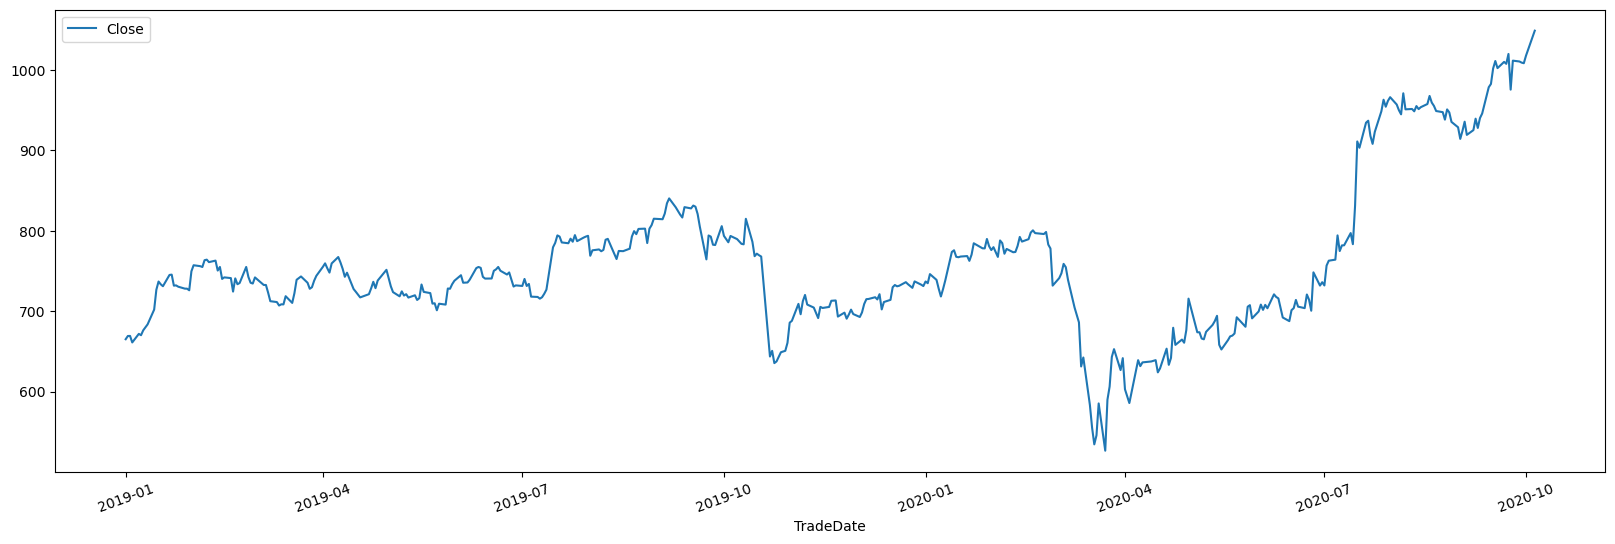

In [30]:
# 创建一个日期列
StockData['TradeDate']=StockData.index
import matplotlib

# 绘制股票价格
%matplotlib inline
StockData.plot(x='TradeDate', y='Close', kind='line', figsize=(20,6), rot=20)

### 准备数据

In [ ]:
# 提取每天的收盘价
FullData=StockData[['Close']].values
print(FullData[0:5])

# 用于神经网络快速训练的特征缩放
from sklearn.preprocessing import StandardScaler, MinMaxScaler

# 在标准化或规范化之间进行选择
#sc = StandardScaler()
sc=MinMaxScaler()

DataScaler = sc.fit(FullData)
X=DataScaler.transform(FullData)
#X=FullData

print('### After Normalization ###')
X[0:5]

### 准备LSTM

In [ ]:
# split into samples
X_samples = list()
y_samples = list()

NumerOfRows = len(X)
TimeSteps=10  # 第二天的价格预测是基于过去多少天的价格

# 遍历值以创建组合
for i in range(TimeSteps , NumerOfRows , 1):
    x_sample = X[i-TimeSteps:i]
    y_sample = X[i]
    X_samples.append(x_sample)
    y_samples.append(y_sample)

################################################
# 将输入重塑为 3D（样本数、时间步长、特征）
X_data=np.array(X_samples)
X_data=X_data.reshape(X_data.shape[0],X_data.shape[1], 1)
print('\n#### Input Data shape ####')
print(X_data.shape)

# 我们不会将 y 重塑为 3D 数据，因为它应该只是一列
y_data=np.array(y_samples)
y_data=y_data.reshape(y_data.shape[0], 1)
print('\n#### Output Data shape ####')
print(y_data.shape)

### 将数据拆分为训练和测试

In [ ]:
# 选择测试数据记录的数量
TestingRecords=5

#将数据拆分为训练和测试
X_train=X_data[:-TestingRecords]
X_test=X_data[-TestingRecords:]
y_train=y_data[:-TestingRecords]
y_test=y_data[-TestingRecords:]

############################################

#打印训练和测试的形状
print('\n#### Training Data shape ####')
print(X_train.shape)
print(y_train.shape)
print('\n#### Testing Data shape ####')
print(X_test.shape)
print(y_test.shape)

### 可视化 LSTM 的输入和输出数据

In [ ]:
# 可视化发送到 LSTM 模型的输入和输出
for inp, out in zip(X_train[0:2], y_train[0:2]):
    print(inp,'--', out)

### 创建深度学习 LSTM 模型


In [ ]:
# 为 LSTM 定义输入形状
TimeSteps=X_train.shape[1]
TotalFeatures=X_train.shape[2]
print("Number of TimeSteps:", TimeSteps)
print("Number of Features:", TotalFeatures)

In [ ]:
#导入 Keras 库和包
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM

#初始化RNN
regressor = Sequential()

# 添加第一个输入隐藏层和 LSTM 层
# return_sequences = True，表示每个时间步的输出要与隐藏的下一层共享
regressor.add(LSTM(units = 10, activation = 'relu', input_shape = (TimeSteps, TotalFeatures), return_sequences=True))

# 添加 Second Second 隐藏层和 LSTM 层
regressor.add(LSTM(units = 5, activation = 'relu', input_shape = (TimeSteps, TotalFeatures), return_sequences=True))

# 添加 Second Third 隐藏层和 LSTM 层
regressor.add(LSTM(units = 5, activation = 'relu', return_sequences=False ))


# 添加输出层
regressor.add(Dense(units = 1))

# 编译 RNN
regressor.compile(optimizer = 'adam', loss = 'mean_squared_error')

##################################################

import time
# 测量模型训练所花费的时间
StartTime=time.time()

# 将 RNN 拟合到训练集
regressor.fit(X_train, y_train, batch_size = 5, epochs = 100)

EndTime=time.time()
print("## Total Time Taken: ", round((EndTime-StartTime)/60), 'Minutes ##')

### 测量模型在测试数据上的准确性

In [ ]:
# 对测试数据进行预测
predicted_Price = regressor.predict(X_test)
predicted_Price = DataScaler.inverse_transform(predicted_Price)

# 获取测试数据的原始价格值
orig=y_test
orig=DataScaler.inverse_transform(y_test)

# 预测的准确性
print('Accuracy:', 100 - (100*(abs(orig-predicted_Price)/orig)).mean())

#可视化结果
import matplotlib.pyplot as plt

plt.plot(predicted_Price, color = 'blue', label = 'Predicted Volume')
plt.plot(orig, color = 'lightblue', label = 'Original Volume')

plt.title('Stock Price Predictions')
plt.xlabel('Trading Date')
plt.xticks(range(TestingRecords), StockData.tail(TestingRecords)['TradeDate'])
plt.ylabel('Stock Price')

plt.legend()
fig=plt.gcf()
fig.set_figwidth(20)
fig.set_figheight(6)
plt.show()

### 可视化完整数据的预测

In [ ]:
#对完整数据生成预测
TrainPredictions=DataScaler.inverse_transform(regressor.predict(X_train))
TestPredictions=DataScaler.inverse_transform(regressor.predict(X_test))

FullDataPredictions=np.append(TrainPredictions, TestPredictions)
FullDataOrig=FullData[TimeSteps:]

# 绘制完整数据
plt.plot(FullDataPredictions, color = 'blue', label = 'Predicted Price')
plt.plot(FullDataOrig , color = 'lightblue', label = 'Original Price')


plt.title('Stock Price Predictions')
plt.xlabel('Trading Date')
plt.ylabel('Stock Price')
plt.legend()
fig=plt.gcf()
fig.set_figwidth(20)
fig.set_figheight(8)
plt.show()